In [110]:
import torch
import trimesh
import numpy as np

import plotly.graph_objects as go

In [111]:
# Ground-truth mesh
# mesh_path = "/data/human_reconstruction/test_render/THUman2/GEO/OBJ/0525/0525.obj"
mesh_path = "/userhome/cs/yukang/data/THuman2.0/data_oriSize/GEO/OBJ/0000/0000.obj"
# mesh_path = "./dennis_test.ply"
mesh_obj = trimesh.load(mesh_path,process=False)

# 3dmm mesh
smpl_path = "/userhome/cs/yukang/data/THuman2.0/data_oriSize/SMPLX/0000/0000_smplx.obj"
# tdmm_path = "./0_0_00_mesh_larger.obj"
# tdmm_path = "./0625_0_0_00_mesh.obj"
# tdmm_obj = trimesh.load(tdmm_path)
smpl_obj = trimesh.load(smpl_path)

unable to load materials from: material0.mtl


In [176]:
# Sample vertices from mesh surface
n_sample = 10000

mesh_vs, _ = trimesh.sample.sample_surface(mesh_obj, n_sample)
# mesh_vs = mesh_obj.vertices
print("mesh: ", mesh_vs.shape)
# print(mesh_vs.min(0), mesh_vs.mean(0), mesh_vs.max(0))

# smpl_vs, _ = trimesh.sample.sample_surface(smpl_obj, n_sample)
# tdmm_vs = tdmm_obj.vertices
# print("tdmm: ",    tdmm_vs.shape)
# print(smpl_vs.min(0), smpl_vs.mean(0), smpl_vs.max(0))
smpl_vs = smpl_obj.vertices
print("smpl: ",    smpl_vs.shape)


mesh_vs = torch.tensor(mesh_vs).permute(1, 0).unsqueeze(0).float()
smpl_vs = torch.tensor(smpl_vs).permute(1, 0).unsqueeze(0).float()


mesh:  (10000, 3)
smpl:  (10475, 3)
torch.Size([1, 3, 10475])


In [195]:
fig = go.Figure()

# mesh_vs = normalize_3d_coordinate(mesh_vs, padding=0.1)
vs = mesh_vs.squeeze(0).permute(1, 0)
# print(query_points.shape)
# vs = mesh_proj.squeeze(0).permute(1, 0)
# vs = query_points.squeeze(0)
# print(vs[:,0].shape)
fig.add_trace(go.Scatter3d(
    x=vs[:,0], y=vs[:,1], z=vs[:,2],
    name='GT',
    mode='markers',
    marker=dict(
        color='orange',
        size=2.5,
    ),
))

# vs = smpl_vs.squeeze(0).permute(1, 0)
vs = points.squeeze(0)
# vs = smpl_proj.squeeze(0).permute(1, 0)
# print(vs[:,0].shape)
fig.add_trace(go.Scatter3d(
    x=vs[:,0], y=-vs[:,1], z=vs[:,2],
    name='SMPL',
    mode='markers',
    marker=dict(
        color='blue',
        size=2.5
    ),
))

fig.show()

In [184]:
calib_path = '/userhome/cs/yukang/data/THuman2.0/data_oriSize/PARAM/0000/0_0_00.npy'
param = np.load(calib_path, allow_pickle=True)
ortho_ratio = param.item().get('ortho_ratio')
scale = param.item().get('scale')
center = param.item().get('center')
R = param.item().get('R')

translate = -np.matmul(R, center).reshape(3, 1)
extrinsic = np.concatenate([R, translate], axis=1)
extrinsic = np.concatenate([extrinsic, np.array([0, 0, 0, 1]).reshape(1, 4)], 0)
            # Match camera space to image pixel space
scale_intrinsic = np.identity(4)
scale_intrinsic[0, 0] = scale / ortho_ratio
scale_intrinsic[1, 1] = -scale / ortho_ratio
scale_intrinsic[2, 2] = scale / ortho_ratio
        # Match image pixel space to image uv space
uv_intrinsic = np.identity(4)
uv_intrinsic[0, 0] = 1.0 / float(512 // 2)
uv_intrinsic[1, 1] = 1.0 / float(512 // 2)
uv_intrinsic[2, 2] = 1.0 / float(512 // 2)
            # Transform under image pixel space
trans_intrinsic = np.identity(4)
intrinsic = np.matmul(trans_intrinsic, np.matmul(uv_intrinsic, scale_intrinsic))
calib = torch.Tensor(np.matmul(intrinsic, extrinsic)).float().unsqueeze(0)
print(calib.shape)

torch.Size([1, 4, 4])


In [185]:
def orthogonal(points, calibrations, transforms=None):
    '''
    Compute the orthogonal projections of 3D points into the image plane by given projection matrix
    :param points: [B, 3, N] Tensor of 3D points
    :param calibrations: [B, 4, 4] Tensor of projection matrix
    :param transforms: [B, 2, 3] Tensor of image transform matrix
    :return: xyz: [B, 3, N] Tensor of xyz coordinates in the image plane
    '''
    rot = calibrations[:, :3, :3]
    trans = calibrations[:, :3, 3:4]
    pts = torch.baddbmm(trans, rot, points)  # [B, 3, N]
    if transforms is not None:
        scale = transforms[:2, :2]
        shift = transforms[:2, 2:3]
        pts[:, :2, :] = torch.baddbmm(shift, scale, pts[:, :2, :])
    return pts

mesh_proj = orthogonal(mesh_vs, calib)
smpl_proj = orthogonal(smpl_vs, calib)
print(mesh_proj.shape)
print(smpl_proj.shape)

torch.Size([1, 3, 10000])
torch.Size([1, 3, 10475])


In [186]:
from common import coordinate2index, normalize_coordinate, normalize_3d_coordinate, map2local
from torch_scatter import scatter_mean
'''
# ICP: bring 3dmm to GT mesh
icp_matrix, icp_smpl_vs, icp_cost = trimesh.registration.icp(smpl_vs, mesh_vs)
# icp_smpl_vs = icp_smpl_vs.unsqueeze(0)
print("tdmm (icp): ", icp_smpl_vs.shape)
# print(icp_smpl_vs.min(0), icp_smpl_vs.mean(0), icp_smpl_vs.max(0))


# tdmm_vs[:, 0] = tdmm_vs[:, 0] - mesh_vs[:, 0].min()
smpl_vs[:, 1] = smpl_vs[:, 1] - mesh_vs[:, 1].min()
smpl_vs = smpl_vs / (mesh_vs[:, 1].max() - mesh_vs[:, 1].min())
smpl_vs[:, 1] = smpl_vs[:, 1] - 0.5
# tdmm_vs[:, 2] = tdmm_vs[:, 2] - mesh_vs[:, 2].min()

# icp_tdmm_vs[:, 0] = icp_tdmm_vs[:, 0] - mesh_vs[:, 0].min()
icp_smpl_vs[:, 1] = icp_smpl_vs[:, 1] - mesh_vs[:, 1].min()
icp_smpl_vs = icp_smpl_vs / (mesh_vs[:, 1].max() - mesh_vs[:, 1].min())
icp_smpl_vs[:, 1] = icp_smpl_vs[:, 1] - 0.5
# icp_tdmm_vs[:, 2] = icp_tdmm_vs[:, 2] - mesh_vs[:, 2].min()

# mesh_vs[:, 0] = mesh_vs[:, 0] - mesh_vs[:, 0].min()
mesh_vs[:, 1] = mesh_vs[:, 1] - mesh_vs[:, 1].min()
mesh_vs = mesh_vs / (mesh_vs[:, 1].max() - mesh_vs[:, 1].min())
mesh_vs[:, 1] = mesh_vs[:, 1] - 0.5
# mesh_vs[:, 2] = mesh_vs[:, 2] - mesh_vs[:, 2].min()

icp_smpl_vs_norm = normalize_3d_coordinate(icp_smpl_vs, padding=0.1)
mesh_vs_norm = normalize_3d_coordinate(mesh_vs, padding=0.1)
smpl_vs_norm = normalize_3d_coordinate(smpl_vs, padding=0.1)
'''

'\n# ICP: bring 3dmm to GT mesh\nicp_matrix, icp_smpl_vs, icp_cost = trimesh.registration.icp(smpl_vs, mesh_vs)\n# icp_smpl_vs = icp_smpl_vs.unsqueeze(0)\nprint("tdmm (icp): ", icp_smpl_vs.shape)\n# print(icp_smpl_vs.min(0), icp_smpl_vs.mean(0), icp_smpl_vs.max(0))\n\n\n# tdmm_vs[:, 0] = tdmm_vs[:, 0] - mesh_vs[:, 0].min()\nsmpl_vs[:, 1] = smpl_vs[:, 1] - mesh_vs[:, 1].min()\nsmpl_vs = smpl_vs / (mesh_vs[:, 1].max() - mesh_vs[:, 1].min())\nsmpl_vs[:, 1] = smpl_vs[:, 1] - 0.5\n# tdmm_vs[:, 2] = tdmm_vs[:, 2] - mesh_vs[:, 2].min()\n\n# icp_tdmm_vs[:, 0] = icp_tdmm_vs[:, 0] - mesh_vs[:, 0].min()\nicp_smpl_vs[:, 1] = icp_smpl_vs[:, 1] - mesh_vs[:, 1].min()\nicp_smpl_vs = icp_smpl_vs / (mesh_vs[:, 1].max() - mesh_vs[:, 1].min())\nicp_smpl_vs[:, 1] = icp_smpl_vs[:, 1] - 0.5\n# icp_tdmm_vs[:, 2] = icp_tdmm_vs[:, 2] - mesh_vs[:, 2].min()\n\n# mesh_vs[:, 0] = mesh_vs[:, 0] - mesh_vs[:, 0].min()\nmesh_vs[:, 1] = mesh_vs[:, 1] - mesh_vs[:, 1].min()\nmesh_vs = mesh_vs / (mesh_vs[:, 1].max() - mesh

In [187]:
plane_type=['grid']
reso_grid=64
padding=0.1
c_dim=128

# from pointnetpp import PointNetPlusPlus
from PointNetFilters import LocalPoolPointnet
from unet3d import UNet3D
# Use as a proxy of feature extraction step
def indices2feats(xyz) :
    """
    
    """
    # pointnetpp_model = PointNetPlusPlus()
    pointnetpp_model = LocalPoolPointnet()
    xyz_pp, l0_points_feature = pointnetpp_model(xyz)
    return l0_points_feature

def verts2point_feat(vs_norm) :
    coord = {}
    index = {}
    if 'grid' in plane_type:
        # coord['grid'] = normalize_3d_coordinate(vs.clone(), padding=padding)
        coord['grid'] = vs_norm.clone()
        index['grid'] = coordinate2index(coord['grid'], reso_grid, coord_type='3d')
    # print(coord['grid'].min(), coord['grid'].max())
    # print(index['grid'].min(), index['grid'].max())
    # print(index['grid'].size(), 'index[grid]')
    coord['grid'] = coord['grid'].permute(0, 2, 1)
    coord['grid'] = torch.from_numpy(np.array(coord['grid']).astype(np.float32))
    # print(coord['grid'].size(), 'coord[grid]')
    # Extract point features
    return indices2feats(coord['grid'])

def query_grid_feat(vs_norm, point_feats):
    """
    vs: query vertices, shape=(B,N,3)
    point_feats: point features, shape=(B,N,c_dim)
    """
    unet3d = UNet3D(128, 256, f_maps=32, num_levels=3, layer_order='cr')
    
    # coords = normalize_3d_coordinate(vs.clone(), padding=padding) #. TODO: verify if needed
    coords = vs_norm.clone()
    indices = coordinate2index(coords, reso_grid, coord_type='3d')
    # scatter grid features from points
    grid_feats = point_feats.new_zeros(vs_norm.size(0), c_dim, reso_grid**3)
    #c = c.permute(0, 2, 1) # TODO: verify if necessary
    print(point_feats.shape, 'point_feats')
    print(indices.shape, 'indices')
    # point_feats = point_feats.permute(0, 2, 1)
    grid_feats = scatter_mean(point_feats, indices, out=grid_feats) # B x C x reso^3
    grid_feats = grid_feats.reshape(vs_norm.size(0), c_dim, reso_grid, reso_grid, reso_grid) # sparce matrix (B x 512 x reso x reso)
    # if self.unet3d is not None:
    grid_feats = unet3d(grid_feats)

    # print(fea_grid.shape)
    
    return grid_feats

In [188]:
from PointNetFilters import LocalPoolPointnet
pointnetpp_model = LocalPoolPointnet()
# points = normalize_3d_coordinate(smpl_proj.permute(0, 2, 1).squeeze(0))
points = smpl_proj.clone()
# points = normalize_3d_coordinate(smpl_proj.permute(0, 2, 1).squeeze(0))
print(points.shape)
# points[:, 0, :] -= points[:, 0, :].min()
# points[:, 1, :] -= points[:, 1, :].min()
# points[:, 2, :] -= points[:, 2, :].min()
# points[:, 1, :] += 1
points /= 2.0
# points -= 0.5
# points[:, 1, :] -= 0.5
# points[:, 1, :] += 1
# points /= 2.0
# points[:, 0, :] -= points[:, 0, :].mean()
# points[:, 1, :] -= points[:, 1, :].mean()
# points[:, 2, :] -= points[:, 2, :].mean()

# points[:, 1, :] -= 0.5
print(points[:, 0, :].min(), points[:, 0, :].max())
print(points[:, 1, :].min(), points[:, 1, :].max())
print(points[:, 2, :].min(), points[:, 2, :].max())
points = normalize_3d_coordinate(points)
# print(points[:, 0, :].min(), points[:, 0, :].max())
# print(points[:, 1, :].min(), points[:, 1, :].max())
# print(points[:, 2, :].min(), points[:, 2, :].max())

points = torch.tensor(points).permute(0, 2, 1)
# points = points.unsqueeze(0)
print(points.shape)
fea = pointnetpp_model(points)
# tdmm_point_feats = verts2point_feat(
#     torch.from_numpy(icp_tdmm_vs_norm).unsqueeze(0)
# )

# tdmm_point_feats = tdmm_point_feats.detach().numpy()
# tdmm_point_feats = tdmm_point_feats.astype(np.float32)
# tdmm_point_feats = tdmm_point_feats.transpose(0, 2, 1)
# print('tdmm_point_feats', tdmm_point_feats.shape)|

# tdmm_grid_feats = query_grid_feat(
#     torch.from_numpy(icp_tdmm_vs_norm).unsqueeze(0), 
#     # vertices after norm
#     torch.from_numpy(tdmm_point_feats),
# )
# print('tdmm_grid_feats', tdmm_grid_feats.shape)
# tdmm_grid_feats = tdmm_grid_feats.transpose(1, 0)
# print("tdmm_grid_feats: ", tdmm_grid_feats.shape)

torch.Size([1, 3, 10475])
tensor(-0.1307) tensor(0.1389)
tensor(-0.4334) tensor(0.4496)
tensor(-0.1678) tensor(0.2042)
torch.Size([1, 10475, 3])


<ipython-input-188-e0bd299d16d4>:29: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



In [189]:
# print(fea.shape)
import torch.nn.functional as F
# query_points = normalize_3d_coordinate(mesh_proj.permute(0, 2, 1).squeeze(0))
query_points = mesh_proj.clone()
# print(query_points.shape)
# print(query_points[:, 0, :].min(), query_points[:, 0, :].max())
# print(query_points[:, 1, :].min(), query_points[:, 1, :].max())
# print(query_points[:, 2, :].min(), query_points[:, 2, :].max())

# query_points[:, 0, :] -= query_points[:, 0, :].min()
# query_points[:, 1, :] -= query_points[:, 1, :].min()
# query_points[:, 2, :] -= query_points[:, 2, :].min()
# query_points[:, 1, :] += 1
query_points /= 2.0
# query_points[:, 1, :] -= 0.5

# query_points[:, 1, :] += 1
# query_points /= 2.0
# query_points[:, 1, :] -= 0.5

# print(query_points[:, 0, :].min(), query_points[:, 0, :].max())
# print(query_points[:, 1, :].min(), query_points[:, 1, :].max())
# print(query_points[:, 2, :].min(), query_points[:, 2, :].max())
query_points = normalize_3d_coordinate(query_points)
# query_points -= 0.5
# query_points *= 2.0
# query_points[:, 0, :] -= query_points[:, 0, :].mean()
# query_points[:, 1, :] -= query_points[:, 1, :].mean()
# query_points[:, 2, :] -= query_points[:, 2, :].mean()
# query_points -= 0.5
# query_points *= 2
print(query_points[:, 0, :].min(), query_points[:, 0, :].max())
print(query_points[:, 1, :].min(), query_points[:, 1, :].max())
print(query_points[:, 2, :].min(), query_points[:, 2, :].max())
# query_points *= -1
# query_points[:, 0, :] -= query_points[:, 0, :].min()
# query_points[:, 1, :] -= query_points[:, 1, :].min()
# query_points[:, 2, :] -= query_points[:, 2, :].min()
# query_points /= 2.0
# query_points[:, 0, :] *= -1
query_points[:, 1, :] *= -1
# query_points *= -1
# query_points = torch.tensor(query_points)
# print(query_points.shape)
query_points = query_points.permute(0, 2, 1)
a = mesh_proj.permute(0, 2, 1).unsqueeze(2).unsqueeze(2)
# print(a.shape)
interp_fea = F.grid_sample(fea, query_points.unsqueeze(2).unsqueeze(2), mode='bilinear')
print(interp_fea.shape)

tensor(0.3896) tensor(0.6204)
tensor(0.1079) tensor(0.8991)
tensor(0.3466) tensor(0.6830)
torch.Size([1, 128, 10000, 1, 1])


In [163]:
print(mesh_proj.shape)
skip = 8 # to reduce the # points to display

fig = go.Figure()
# xs,ys,zs = torch.from_numpy(icp_tdmm_vs_norm).unsqueeze(0).permute(0, 2, 1)[0, :,::skip]
xs,ys,zs = mesh_proj[0, :,::skip]
# cs = interp_icp_smpl_feats.squeeze()[0, ::skip].detach().numpy()
cs = interp_fea.squeeze()[10, ::skip].detach().numpy()
# print(interp_icp_tdmm_feats.shape, 'interp_icp_smpl_feats')
# cond = torch.logical_and((0.4<zs),(zs<0.6))
# xs,ys,zs = xs[cond], ys[cond], zs[cond]
# cs = cs[cond]

# cond = cs>0.1
# xs,ys,zs = xs[cond], ys[cond], zs[cond]
# cs = cs[cond]

print(xs.shape, ys.shape, zs.shape)
print(cs.shape)
fig.add_trace(go.Scatter3d(
    x=xs, y=ys, z=zs,
    mode='markers',
    marker=dict(
        color=cs,
        #color='red',
        size=2.5,
        opacity=0.75,
    ),
))


torch.Size([1, 3, 10000])
torch.Size([1250]) torch.Size([1250]) torch.Size([1250])
(1250,)


In [56]:
print(query_points[:, 1, :].mean())

tensor(0.6065)


In [136]:
# https://github.com/simpleig/Geo-PIFu/blob/0b570802d6c46d7230bb505e2a8c3d5a1cf7086a/geopifu/lib/geometry.py#L38
def index_3d(feat, XYZ):
    """
    input
        feat: (C,B,D,H,W) 3d deepVoxels' features in unit cube [0,1]^3
        XYZ : (B,3,N), 3d coords. for tri-linear sampling
    return
        samples: (B,C,N) sampled features from deepVoxels
    """

    # init.
    depthVoxels  = feat.shape[2] # 32
    heightVoxels = feat.shape[3] # 48
    widthVoxels  = feat.shape[4] # 32

    
    
    # normalize into torch.float32 of W~(0,32), H~(0,48), D~(0,32)
    X = XYZ[:, 0, :] # (B, N)
    Y = XYZ[:, 1, :] # (B, N)
    Z = XYZ[:, 2, :] # (B, N)
# #     X = (X*(consts.dim_h/consts.dim_w)+1.) / 2. * (widthVoxels-1.)
# #     Y = (Y+1.) / 2. * (heightVoxels-1.)
# #     Z = (Z*(consts.dim_h/consts.dim_w)+1.) / 2. * (depthVoxels-1.)
#     print("B: ", X.min(), X.mean(), X.max())
#     print("B: ", Y.min(), Y.mean(), Y.max())
#     print("B: ", Z.min(), Z.mean(), Z.max())
# #     X = (X-X.min(1)[0]) / (X.max(1)[0]-X.min(1)[0]) * (widthVoxels-1.)
# #     Y = (Y-Y.min(1)[0]) / (Y.max(1)[0]-Y.min(1)[0]) * (heightVoxels-1.)
# #     Z = (Z-Z.min(1)[0]) / (Z.max(1)[0]-Z.min(1)[0]) * (depthVoxels-1.)
#     X = (X-X.min(1)[0]) / (X.max(1)[0]-X.min(1)[0])
#     Y = (Y-Y.min(1)[0]) / (Y.max(1)[0]-Y.min(1)[0])
#     Z = (Z-Z.min(1)[0]) / (Z.max(1)[0]-Z.min(1)[0])
#     print("2: ", X.min(), X.mean(), X.max())
#     print("2: ", Y.min(), Y.mean(), Y.max())
#     print("2: ", Z.min(), Z.mean(), Z.max())
    X = X * (widthVoxels-1.)
    Y = Y * (heightVoxels-1.)
    Z = Z * (depthVoxels-1.)
#     print("A: ", X.min(), X.mean(), X.max())
#     print("A: ", Y.min(), Y.mean(), Y.max())
#     print("A: ", Z.min(), Z.mean(), Z.max())

    # get min, max of torch.int64
    x0 = X.floor().long() # (B, N)
    x1 = (x0 + 1).long()  # (B, N)
    y0 = Y.floor().long() # (B, N)
    y1 = (y0 + 1).long()  # (B, N)
    z0 = Z.floor().long() # (B, N)
    z1 = (z0 + 1).long()  # (B, N)

    # clip into valid ranges, torch.int64
    x0 = torch.clamp(x0, min=0, max=widthVoxels  - 1) # (B, N)
    x1 = torch.clamp(x1, min=0, max=widthVoxels  - 1)
    y0 = torch.clamp(y0, min=0, max=heightVoxels - 1)
    y1 = torch.clamp(y1, min=0, max=heightVoxels - 1)
    z0 = torch.clamp(z0, min=0, max=depthVoxels  - 1)
    z1 = torch.clamp(z1, min=0, max=depthVoxels  - 1)

    # compute offset, torch.float32
    x_ = X - x0.float() # (B, N)
    y_ = Y - y0.float()
    z_ = Z - z0.float()

    # get idx for batch
    ix = torch.zeros_like(x0) # (B,N)
    for j in range(ix.shape[0]): ix[j] += j

    # tri-linear interpolation, (C,B,N)
    out = (feat[:, ix, z0, y0, x0]*(1-x_)*(1-y_)*(1-z_) +
           feat[:, ix, z1, y0, x0]*x_*(1-y_)*(1-z_) +
           feat[:, ix, z0, y1, x0]*(1-x_)*y_*(1-z_) +
           feat[:, ix, z0, y0, x1]*(1-x_)*(1-y_)*z_ +
           feat[:, ix, z1, y0, x1]*x_*(1-y_)*z_ +
           feat[:, ix, z0, y1, x1]*(1-x_)*y_*z_ +
           feat[:, ix, z1, y1, x0]*x_*y_*(1-z_) +
           feat[:, ix, z1, y1, x1]*x_*y_*z_)

    # (B,C,N)
    return out.transpose(0,1).contiguous()

In [157]:

# interp_icp_tdmm_feats = index_3d(
#     tdmm_grid_feats,
#     torch.from_numpy(icp_tdmm_vs_norm).unsqueeze(0).permute(0, 2, 1), # vs after norm
# )
print(fea.shape)
interp_feats = index_3d(
    fea.permute(1, 0, 2, 3, 4),
    query_points.permute(0, 2, 1), # vs after norm
).squeeze(0)


print("interp_icp_tdmm_feats: ", interp_feats.shape)


# interp_icp_tdmm_feats_query = index_3d(
#     tdmm_grid_feats,
#     torch.from_numpy(mesh_vs_norm).unsqueeze(0).permute(0, 2, 1), # vs after norm
# )
# interp_icp_tdmm_feats_query = index_3d(
#     fea,
#     torch.from_numpy(mesh_vs_norm).unsqueeze(0).permute(0, 2, 1), # vs after norm
# )

# print("interp_icp_tdmm_feats_query: ", interp_icp_tdmm_feats_query.shape)

torch.Size([1, 128, 64, 64, 64])
interp_icp_tdmm_feats:  torch.Size([128, 10000])


torch.Size([37753]) torch.Size([37753]) torch.Size([37753])
(862,)


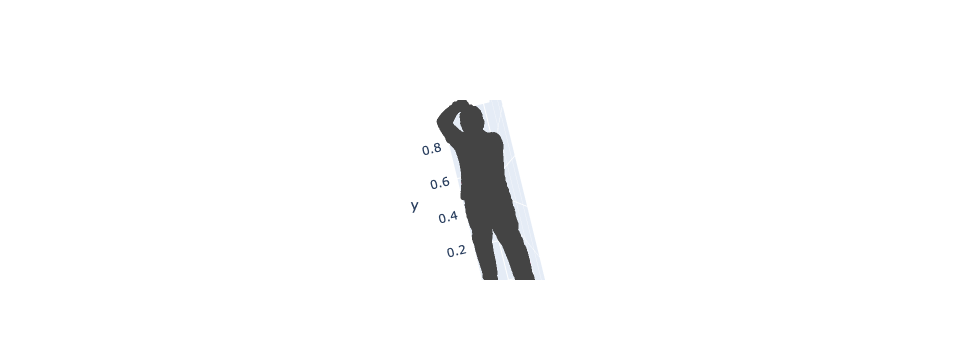

In [23]:
# Show features queried around 3dmm
skip = 8 # to reduce the # points to display

fig = go.Figure()
# xs,ys,zs = torch.from_numpy(icp_tdmm_vs_norm).unsqueeze(0).permute(0, 2, 1)[0, :,::skip]
xs,ys,zs = torch.from_numpy(mesh_vs_norm).unsqueeze(0).permute(0, 2, 1)[0, :,::skip]
# cs = interp_icp_smpl_feats.squeeze()[0, ::skip].detach().numpy()
cs = interp_icp_tdmm_feats.squeeze()[0, ::skip].detach().numpy()
# print(interp_icp_tdmm_feats.shape, 'interp_icp_smpl_feats')
# cond = torch.logical_and((0.4<zs),(zs<0.6))
# xs,ys,zs = xs[cond], ys[cond], zs[cond]
# cs = cs[cond]

# cond = cs>0.1
# xs,ys,zs = xs[cond], ys[cond], zs[cond]
# cs = cs[cond]

print(xs.shape, ys.shape, zs.shape)
print(cs.shape)
fig.add_trace(go.Scatter3d(
    x=xs, y=ys, z=zs,
    mode='markers',
    marker=dict(
        color=cs,
        #color='red',
        size=2.5,
        opacity=0.75,
    ),
))

# Display background features
# skip = 4 # to reduce the # points to display
# xs,ys,zs = q_vs_norm[0,:,::skip]
# cs = interp_q_feats.squeeze()[0, ::skip].detach().numpy()

# cond = torch.logical_and((0.45<zs),(zs<0.55))
# xs,ys,zs = xs[cond], ys[cond], zs[cond]
# cs = cs[cond]

# cond = torch.logical_and((-0.3<xs),(xs<0.3))
# xs,ys,zs = xs[cond], ys[cond], zs[cond]
# cs = cs[cond]


# cond = cs>0.1
# xs,ys,zs = xs[cond], ys[cond], zs[cond]
# cs = cs[cond]

# print(xs.shape, ys.shape, zs.shape)
# print(cs.shape)
# fig.add_trace(go.Scatter3d(
#     x=xs, y=ys, z=zs,
#     mode='markers',
#     marker=dict(
#         color=cs,
#         size=1.5,
#         opacity=0.2,
#     ),
# ))


# With original mesh
skip = 8
# xs,ys,zs = torch.from_numpy(mesh_vs_norm).unsqueeze(0).permute(0, 2, 1)[0,:,::skip] # vs after norm
xs,ys,zs = torch.from_numpy(mesh_vs).unsqueeze(0).permute(0, 2, 1)[0,:,::skip] # vs after norm

# cond = torch.logical_and((0.4<zs),(zs<0.6))
# xs,ys,zs = xs[cond], ys[cond], zs[cond]

# fig.add_trace(go.Scatter3d(
#     x=xs, y=ys, z=zs,
#     mode='markers',
#     marker=dict(
#         color='green',
#         size=2.5,
#         #opacity=0.5,
#     ),
# ))

# fig.update_layout(
#     scene=dict(
#         xaxis=dict(range=[-0.5,0.5]),
#         yaxis=dict(range=[-0.5,0.5]),
#         zaxis=dict(range=[-0.5,0.5]),
#     ),
# )


fig.show()